In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Use inspector to get columns
inspector = inspect(engine)
meas_columns = inspector.get_columns("measurement")
stat_columns = inspector.get_columns("station")
for c in meas_columns:
    print(c['name'], c["type"])
for c in stat_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

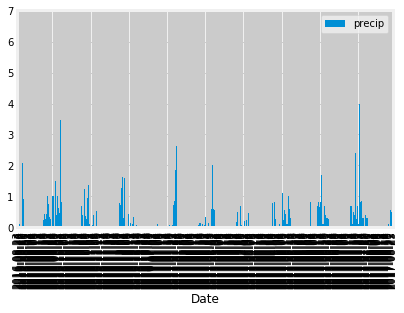

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# precip_all = session.query(Measurement.date, Measurement.prcp).all()
# precip_all

# Perform a query to retrieve the data and precipitation scores
precip_12mo = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23")\
            .filter(Measurement.date <= "2017-08-23").group_by(Measurement.date).order_by(Measurement.date).all()
precip_12mo

# Save the query results as a Pandas DataFrame and set the index to the date column
dates = [x[0] for x in precip_12mo]
precip = [x[1] for x in precip_12mo]

prcp_df = pd.DataFrame({"date":dates,
                      "precip":precip}, index=dates)

prcp_df.head()

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind="bar")
plt.xlabel("Date")
plt.show()
# Rotate the xticks for the dates


![precipitation](Images/precipitation.png)

In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precip
count,340.000000
mean,0.509588
std,0.815438
min,0.000000
25%,0.020000
50%,0.190000
75%,0.700000
max,6.700000


In [24]:
# How many stations are available in this dataset?
num_sessions = session.query(Station).group_by(Station.name).count()
num_sessions

9

In [35]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = session.query(Station.station, func.count(Measurement.id)).\
                filter(Station.station == Measurement.station).group_by(Station.station).\
                order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
                                    func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
most_active_station_info

[(54.0, 85.0, 71.66378066378067)]

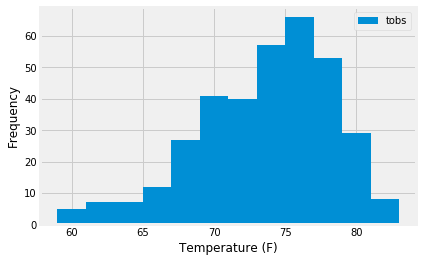

In [40]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = "USC00519281"

tobs_12mo = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= "2016-08-23").filter(Measurement.date <= "2017-08-23").all()

tobs_12mo = np.ravel(tobs_12mo)
tobs_12mo

plt.hist(tobs_12mo, bins=12, label="tobs")
plt.legend(loc="best")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.show()

In [42]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = "2014-06-16"
end_date = "2014-06-24"

trip_temps = calc_temps(start_date, end_date)
trip_temps

[(68.0, 73.87878787878788, 84.0)]

([], <a list of 0 Text xticklabel objects>)

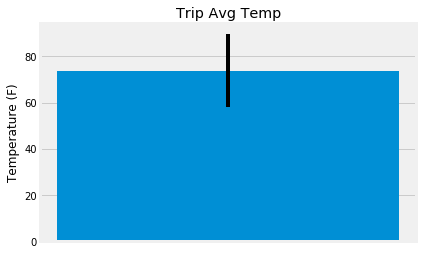

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_peak = trip_temps[0][2] - trip_temps[0][0]

plt.bar(0, trip_temps[0][1], 0.2, yerr=peak_peak)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.xticks([])

In [59]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_rainfall = session.query(Measurement.station, Station.name, Station.latitude,
                              Station.longitude, Station.elevation, Measurement.prcp).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).\
                    group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
trip_rainfall

[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.14),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.08),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.07),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.05),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.03),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.01),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]

## Optional Challenge Assignment

In [62]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [68]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []

# Set the start and end date of the trip
start_date = "06-16"
end_date = "06-25"

# Use the start and end date to create a range of dates
dates = [f"06-{num}" for num in range(16, 26)]

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in dates:
    norm = daily_normals(date)
    normals.extend(norm)
    
normals

[(69.0, 75.41379310344827, 81.0),
 (68.0, 74.59322033898304, 81.0),
 (69.0, 74.60344827586206, 80.0),
 (70.0, 75.44067796610169, 82.0),
 (68.0, 73.96491228070175, 85.0),
 (68.0, 74.75862068965517, 82.0),
 (69.0, 75.15789473684211, 81.0),
 (68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0)]

In [93]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin = [x[0] for x in normals]
tavg = [x[1] for x in normals]
tmax = [x[2] for x in normals]

year_dates = [f"2016-{date}" for date in dates]
year_dates

trip_normals = pd.DataFrame({"tmin":tmin, "tavg":tavg, "tmax":tmax, "date":year_dates}, index=year_dates)
trip_normals.head()

,tmin,tavg,tmax,date
2016-06-16,69.0,75.413793,81.0,2016-06-16
2016-06-17,68.0,74.593220,81.0,2016-06-17
2016-06-18,69.0,74.603448,80.0,2016-06-18
2016-06-19,70.0,75.440678,82.0,2016-06-19
2016-06-20,68.0,73.964912,85.0,2016-06-20


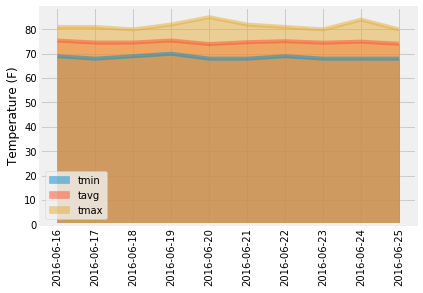

In [117]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals.plot(kind="area", stacked=False)
plt.legend(loc="best")
plt.ylabel("Temperature (F)")
plt.xticks(range(len(trip_normals["date"])), trip_normals["date"], rotation="90")
plt.show()